In [1]:
### imports

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import keras
from scripts.ksplot import make_ks_plot
import pickle

In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 16,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [3]:
# load training and testing arrays along with their labels and variable and label names
# such a file is created at the end of the explore.ipynb notebook
with np.load('root_files/train_test_49variables.npz') as f:
    X_train = f['X_train']
    y_train = f['y_train']
    features = f['variables'].tolist()
    labels = f['labels'].tolist()
    
with np.load('root_files/validate_49variables.npz') as f:
    X_test = f['X_test']
    y_test = f['y_test']
    features = f['variables'].tolist()
    labels = f['labels'].tolist()

In [4]:
to_use = [
         # number of tracks and number of SVs always used
          'fj_jetNTracks',
          'fj_nSV',
         # adding full jet kinematics
          'fj_eta',
          'fj_mass',
          'fj_phi',
          'fj_pt',
         # adding kinematic variables defined for the two soft drop subjets
          'fj_ptDR',
          'fj_relptdiff',
          'fj_sdn2',
          'fj_sdsj1_eta',
          'fj_sdsj1_mass',
          'fj_sdsj1_phi',
          'fj_sdsj1_pt',
          'fj_sdsj1_ptD',
          'fj_sdsj2_eta',
          'fj_sdsj2_mass',
          'fj_sdsj2_phi',
          'fj_sdsj2_pt',
          'fj_sdsj2_ptD',
          'fj_z_ratio',
#          # adding N-subjettiness variables
          'fj_tau1',
          'fj_tau2',
          'fj_tau3',
          'fj_tau21',
          'fj_tau32',
#          # adding variables related to N-subjettines axes
          'fj_tau0_trackEtaRel_0',
          'fj_tau0_trackEtaRel_1',
          'fj_tau0_trackEtaRel_2',
          'fj_tau1_trackEtaRel_0',
          'fj_tau1_trackEtaRel_1',
          'fj_tau1_trackEtaRel_2',
          'fj_tau_vertexMass_0',
          'fj_tau_vertexMass_1',
          'fj_tau_vertexEnergyRatio_0',
          'fj_tau_vertexEnergyRatio_1',
          'fj_tau_flightDistance2dSig_0',
          'fj_tau_flightDistance2dSig_1',
          'fj_tau_vertexDeltaR_0',
#          # adding impact parameter significance variables
          'fj_trackSipdSig_0',
          'fj_trackSipdSig_1',
          'fj_trackSipdSig_2',
          'fj_trackSipdSig_3',
          'fj_trackSipdSig_0_0',
          'fj_trackSipdSig_0_1',
          'fj_trackSipdSig_1_0',
          'fj_trackSipdSig_1_1',
          'fj_trackSip2dSigAboveCharm_0',
          'fj_trackSip2dSigAboveBottom_0',
          'fj_trackSip2dSigAboveBottom_1'
         ]

num_of_variables = len(to_use)
indices = sorted([features.index(i) for i in to_use])
X_train_final = X_train[:,indices]
X_test_final = X_test[:,indices]

print(X_train_final.shape)
print(X_test_final.shape)

(3565826, 49)
(455742, 49)


In [5]:
model = keras.models.load_model(f"model_checkpoints/MLP_{num_of_variables}variables.h5")

In [6]:
evaluation_train = model.evaluate(X_train_final,y_train)
evaluation_test = model.evaluate(X_test_final,y_test)
accuracy = evaluation_test[1]
print(evaluation_train)
print(evaluation_test)

predict_array_train = model.predict(X_train_final)
predict_array_test = model.predict(X_test_final)

   272/111433 [..............................] - ETA: 41s - loss: 0.1611 - accuracy: 0.9362   

2022-11-30 00:33:12.517369: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14242/14242 [==============================] - 5s 348us/step - loss: 0.1582 - accuracy: 0.9372
[0.15552543103694916, 0.9384591579437256]
[0.15815746784210205, 0.9372122883796692]
14242/14242 [==============================] - 4s 309us/step


In [7]:
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,0])
np.savez(f'plots/ROC_MLP_{num_of_variables}variables_test', fpr = fpr, tpr = tpr)

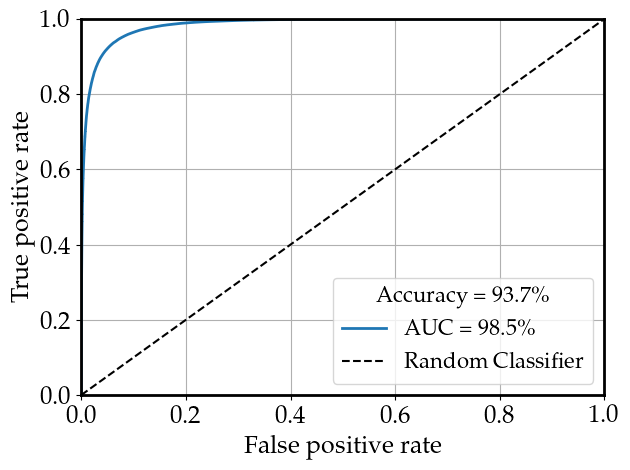

In [8]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right', title=f'Accuracy = {accuracy*100:.1f}\%')
plt.tight_layout()
plt.savefig(f'plots/ROC_MLP_{num_of_variables}variables_test.pdf')
plt.show()

In [9]:
# create KS histogram of classifier output to check for overtraining
fig = make_ks_plot(y_train[:,0], predict_array_train[:,0],
                   y_test[:,0], predict_array_test[:,0])
fig.savefig(f'plots/KS_MLP_{num_of_variables}variables_test.pdf')

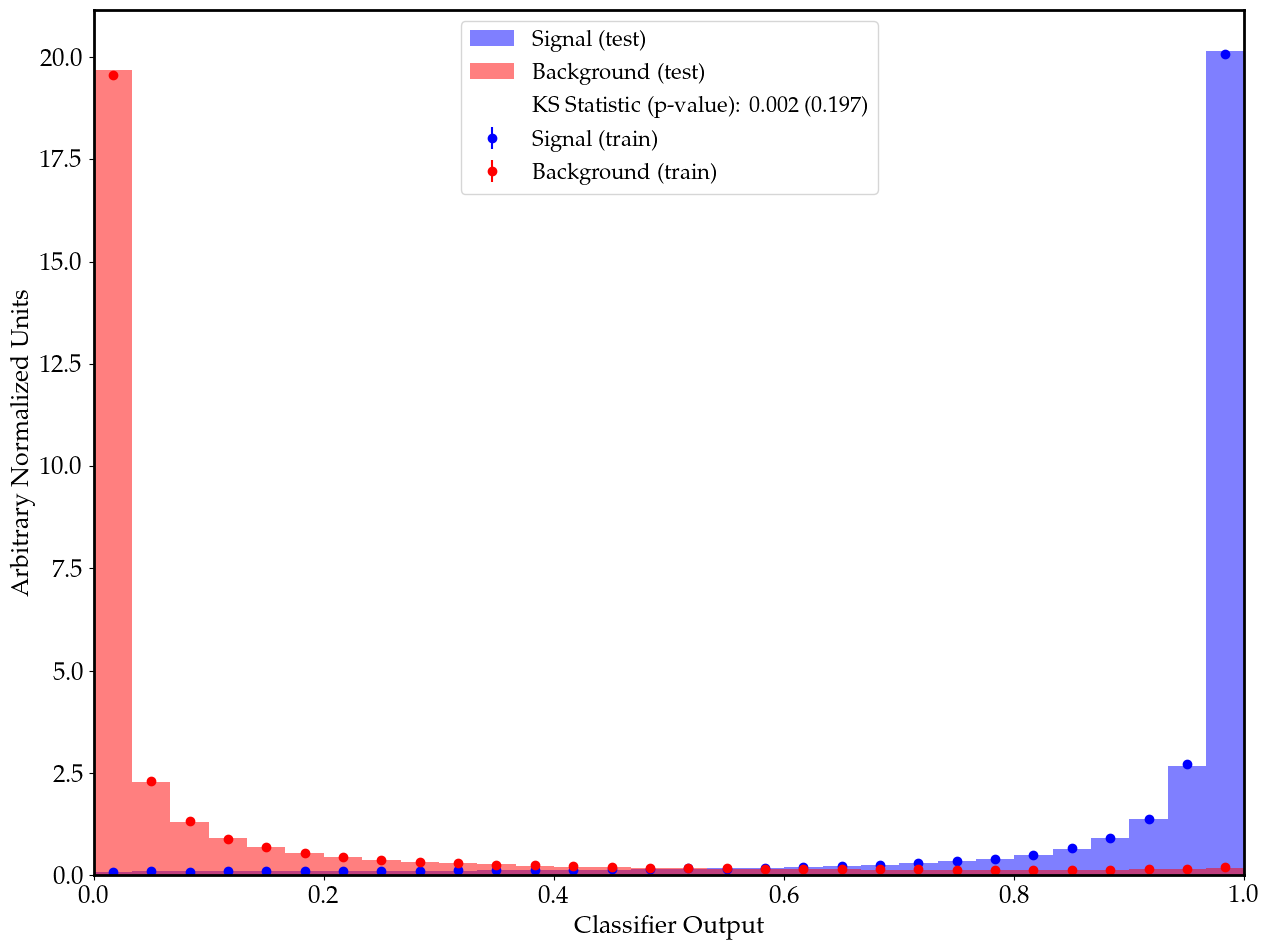

In [10]:
fig

In [11]:
bdt = XGBClassifier()

In [12]:
bdt.load_model(f"model_checkpoints/BDT_{num_of_variables}variables.json")

In [13]:
# print the accuracies of the BDT on the training and testing data sets
print(bdt.score(X_train_final, y_train))
accuracy = bdt.score(X_test_final, y_test)
print(accuracy)

0.9420776560606154
0.9386341394912033


In [14]:
# run BDT inference on train and test data sets and create ROC curve
predict_array_train = bdt.predict_proba(X_train_final)
predict_array_test = bdt.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,0])
np.savez(f'plots/ROC_BDT_{num_of_variables}variables_test', fpr = fpr, tpr = tpr)

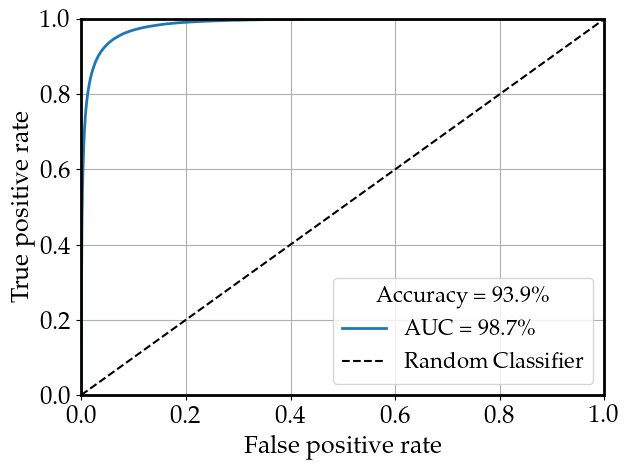

In [15]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right', title=f'Accuracy = {accuracy*100:.1f}\%')
plt.tight_layout()
plt.savefig(f'plots/ROC_BDT_{num_of_variables}variables_test.pdf')
plt.show()

In [16]:
# create KS histogram of classifier output to check for overtraining
fig = make_ks_plot(y_train[:,0], predict_array_train[:,0],
                   y_test[:,0], predict_array_test[:,0])
fig.savefig(f'plots/KS_BDT_{num_of_variables}variables_test.pdf')

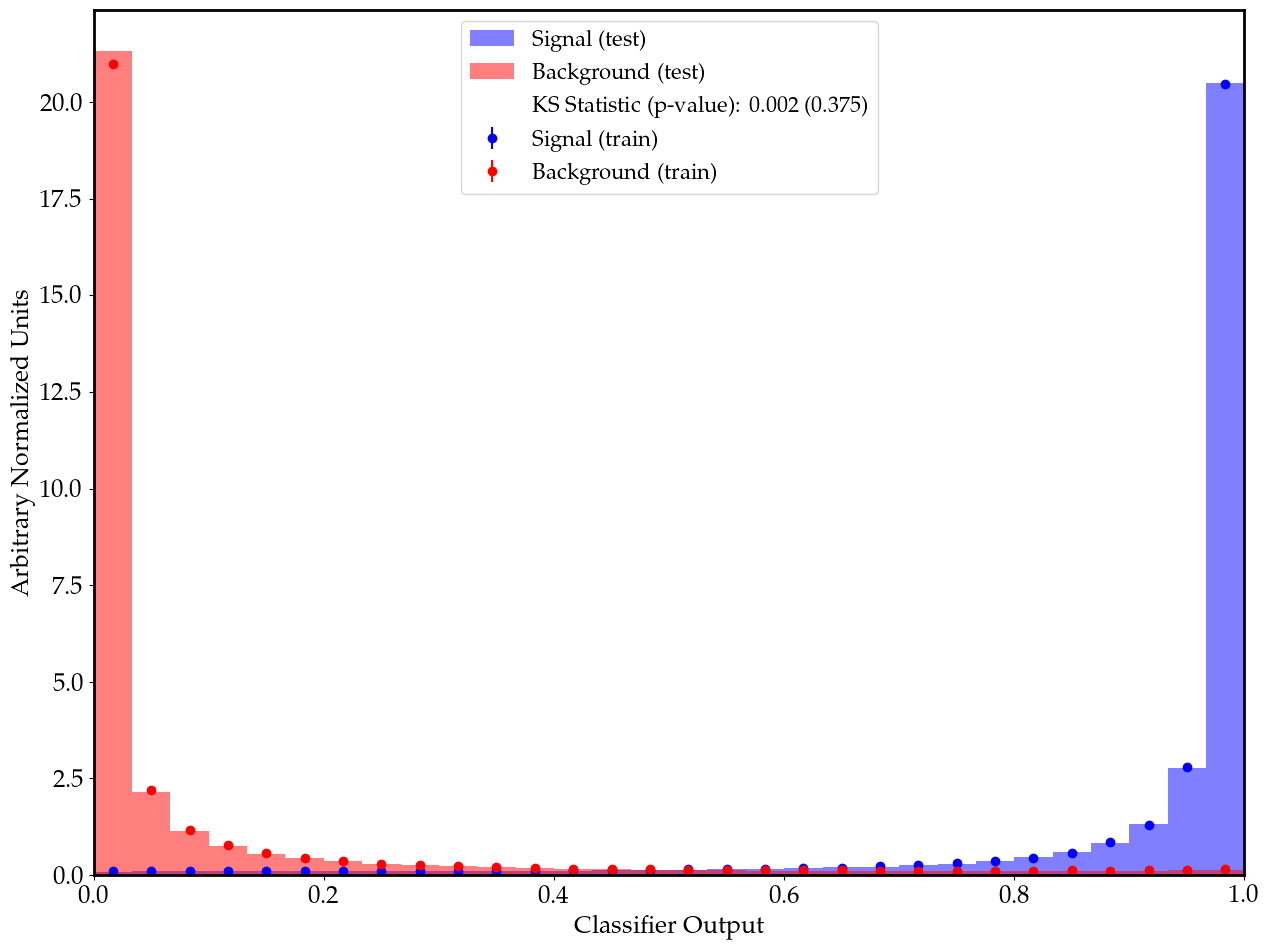

In [17]:
fig

In [18]:
with open(f"model_checkpoints/LDA_{num_of_variables}variables.pkl", 'rb') as f:
    fisher = pickle.load(f)

In [19]:
# print the accuracies of the LDA classifier on the training and testing data sets
print(fisher.score(X_train_final, y_train[:,0]))
accuracy = fisher.score(X_test_final, y_test[:,0])
print(accuracy)

0.858677624763519
0.8583584571972739


In [20]:
# run LDA classifier inference on train and test data sets and create ROC curve
predict_array_train = fisher.predict_proba(X_train_final)
predict_array_test = fisher.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,1])
np.savez(f'plots/ROC_LDA_{num_of_variables}variables_test', fpr = fpr, tpr = tpr)

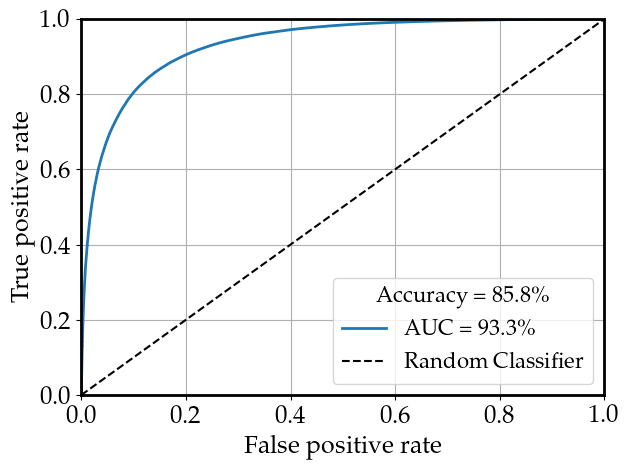

In [21]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right', title=f'Accuracy = {accuracy*100:.1f}\%')
plt.tight_layout()
plt.savefig(f'plots/ROC_LDA_{num_of_variables}variables_test.pdf')
plt.show()

In [22]:
# create KS histogram of classifier output to check for overtraining
fig = make_ks_plot(y_train[:,0], predict_array_train[:,1],
                   y_test[:,0], predict_array_test[:,1])
fig.savefig(f'plots/KS_LDA_{num_of_variables}variables_test.pdf')

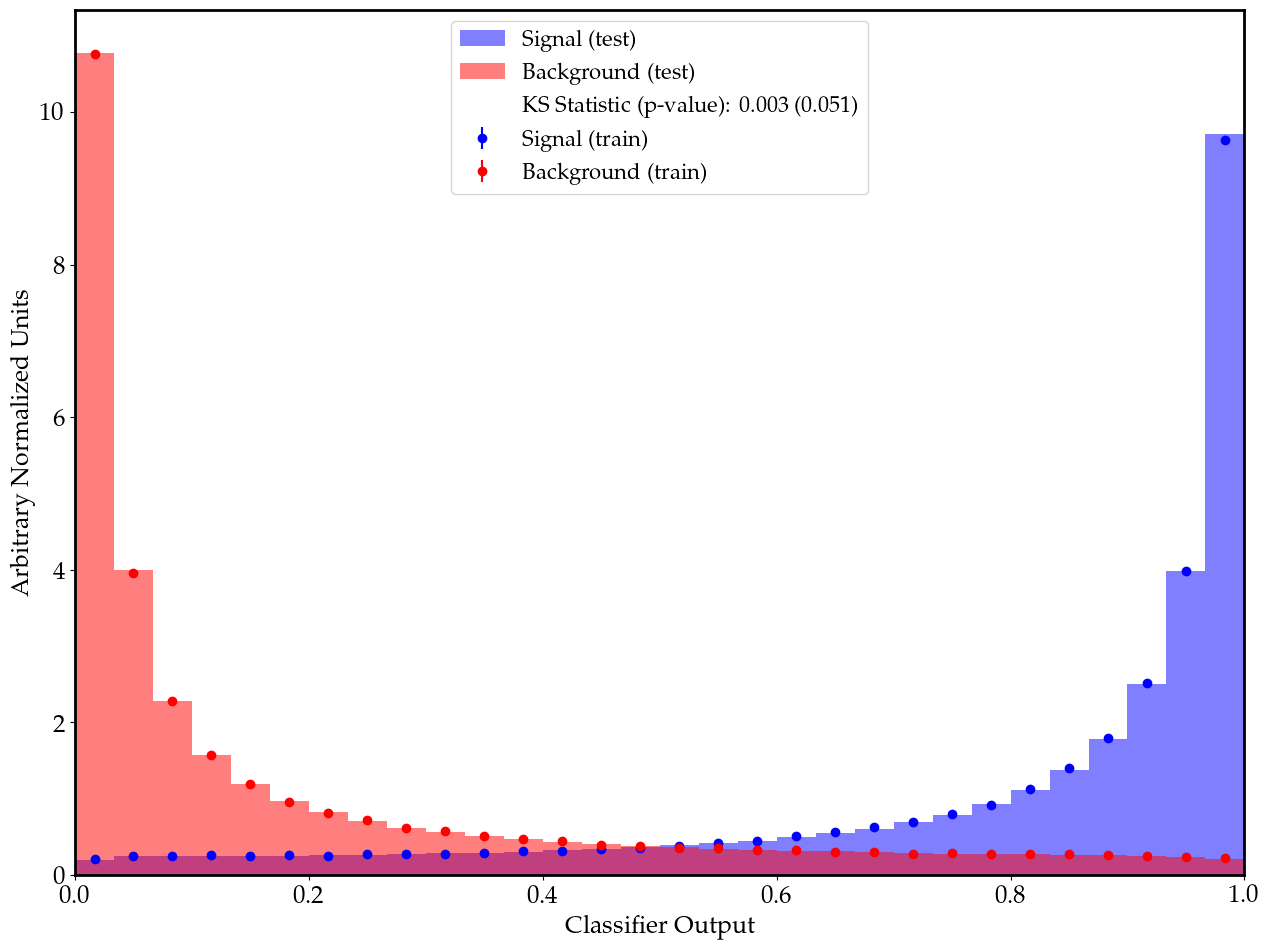

In [23]:
fig